# Figure 8

Run the steps below to generate the data and plot of Figure 8.

**Lennart van Sluijs** // 2019 Jan 8 // Leiden Observatory // vansluijs@strw.leidenuniv.nl

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import numpy as np
from astropy.io import fits
from astropy import constants as const
from astropy import units as u
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from rmmodel_func import make_lineprofile, make_star, make_planet
from scipy.interpolate import interp1d
from aux import *
import warnings

# Load stellar parameters
These are the stellar parameters used for the different spectral types for which lineprofiles are simulated.

In [20]:
inputfolder = '../data/'
starparams = np.loadtxt(os.path.join(inputfolder, 'stellarparams.txt'), dtype = 'str')

#  Simulate oversampled lineprofiles

In [16]:
def thermalbroadening(T, vref = 20, Tref = 8000):
    """
    Description:
        Calculate the thermal broadening using a scaling relation that uses
        v_broadening prop sqrt(T_k). This is been calibrated on Beta Pictoris
        which has a thermal broadening of approx 20 km/s for T = 8620.
    Input:
        T - stellar temperature
        vref, Tref - reference stellar thermal broadening and temperature
    """
    
    # apply scaling relation
    v = vref * np.sqrt( T / Tref )
    
    return v

def simtransit(phase, Rs_Rjup, Rp_Rjup, veq, l_fwhm, radvel, A):
    """
    Description:
        Uses de code of Ernst de Mooij to simulate a line distortion for
        a transiting planet.
    Input:
        phase - orbital phase to evaluate planet
        Rs_Rjup - stellar radius [Rjup]
        Rp_Rjup - planet radius [Rp]
        veq - projected stellar rotational velocity [km/s]
        l_fwhm - thermal broadening, intrinsic line FWHM [km/s]
        radvel - radial velocity grid
        A - intrinsic line depth
    Output:
        diff_lineprof - distortion of lineprofile by planet
    """

    Rs=510 # radius of the star in pixels
    RpRs=Rp_Rjup/Rs_Rjup # radius of planet in stellar radii
    Rp=RpRs*Rs # radius of the planet in stellar radii
    npix_star = 1025 # number of pixels in the stellar map
    OSF = 10 # oversampling factor for star to avoid jagged edges
    map0=np.zeros((npix_star*OSF,npix_star*OSF)) # Map for calculating 
    # star, needed for C code
    xc=511.5 # x-coordinate of disk centre
    yc=511.5 # y-coordinate of disk centre
    lw=l_fwhm/2.35 # Intinsice line width in sigma (km/s)
    u1, u2 = (0., 0.) # ignore limb darkening
    u1=0.2752
    u2=0.3790 
    b = 0 # impact parameter
    theta = 0 #projected spin-orbit misalignment
    aRp = 100. # semi-major axis
    
    vgrid = np.copy(radvel) 
    profile = make_lineprofile(npix_star, Rs, xc, vgrid, A, veq, lw)

    star = make_star(npix_star, OSF, xc, yc, Rs, u1, u2, map0)
    sflux = star.sum(axis=1)

    improf = np.sum(sflux[:,np.newaxis]*profile,axis=0)
    normalisation = improf[0]
    improf = improf/normalisation

    # set up the orbit including a spin-orbit misalignment
    x0 = aRp * np.sin(2. * np.pi * phase)
    y0 = b * np.cos(2. * np.pi * phase)
    x1 = (x0 * np.cos(theta) - y0 * np.sin(theta)) * Rs + xc
    y1 = (x0 * np.sin(theta) + y0 * np.cos(theta)) * Rs + yc
    
    # define some basic arrays
    line_profile1=np.zeros( (x1.shape[0],vgrid.shape[0]) )
    img1=np.zeros( (x1.shape[0],npix_star,npix_star) )
    
    # loop over the positions of the planet
    for i in range(x1.shape[0]):    
        tmap1=star*make_planet(npix_star,OSF,y1[i],x1[i],Rp,map0)
        sflux=tmap1.sum(axis=0)
        line_profile1[i,:]=np.dot(sflux,profile)/normalisation
        img1[i,:,:]=tmap1
    
    return line_profile1


def generate_diff_lineprofs(starparams, Rp_list, outputfolder):
    """
    Description:
        Simulate the lineprofile distortion by a planet for different
        projected rotational velocity and
        planet radii.
    Input:
        veq_list - list of v sin i values to use as grid
        RpRs_list - list of planet radius/stellar radius to use as grid
        Rinst_list - list of instrumental resolution to try
        outputfolder - save plot and relevant arrays here
    """
    
    # define some fixed parameters
    phase = np.linspace(-0.1, 0.1, 3)
    A = 0.8
    osf = 2000 # oversampling used for the velocity grid
    outputfolder = os.path.join(outputfolder, 'sim')
    vmax = 1000
    radvel = np.linspace(-vmax, vmax, osf)
    
    # allocate memory
    Nsim, n = (starparams.shape[0] * len(Rp_list), 0)
    for i in range(starparams.shape[0]):
        for j, Rp in enumerate(Rp_list):
            
            # print progress
            n += 1
            print('Simulating lineprofile ('+str(n)+'/'+str(Nsim)+')')
            
            # extract right stellar parameters
            Rs = float(starparams[i, 1])
            veq = float(starparams[i, 3])
            Teff = float(starparams[i, 4])
            l_fwhm = thermalbroadening(Teff) # km/s
            
            # get planet distortion by RM-effect
            lineprof = simtransit(phase, Rs, Rp, veq,
                                       l_fwhm, radvel, A)
            
            # store in memory
            outputfolder_sim = os.path.join(outputfolder, 'sim' + str(n))
            if not os.path.exists(outputfolder_sim):
                os.makedirs(outputfolder_sim)
            np.save(os.path.join(outputfolder_sim,
                                 'lineprof.npy'), lineprof)
            np.save(os.path.join(outputfolder_sim,
                                 'radvel.npy'), radvel)
            
    # save datacube and information on axes
    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)
    np.save(os.path.join(outputfolder, 'Rp_list.npy'), Rp_list)
    np.save(os.path.join(outputfolder, 'starparams.npy'), starparams)

# simulate for a Jupiter- Saturn and Neptune-sized planet
Rjup_solRad = 0.1004901538 # [solRad]
Rsat_solRad = 0.08370274543 # [solRad]
Rnep_solRad = 0.03539169182 # [solRad]
Rp_list = np.array([Rjup_solRad, Rsat_solRad, Rnep_solRad])
outputfolder = '../output/figure8'

# generate oversampled in-transit lineprofiles with the out-of-transit
# lineprofiles subtracted off.
generate_diff_lineprofs(starparams, Rp_list, outputfolder)

Simulating lineprofile (1/18)
Simulating lineprofile (2/18)
Simulating lineprofile (3/18)
Simulating lineprofile (4/18)
Simulating lineprofile (5/18)
Simulating lineprofile (6/18)
Simulating lineprofile (7/18)
Simulating lineprofile (8/18)
Simulating lineprofile (9/18)
Simulating lineprofile (10/18)
Simulating lineprofile (11/18)
Simulating lineprofile (12/18)
Simulating lineprofile (13/18)
Simulating lineprofile (14/18)
Simulating lineprofile (15/18)
Simulating lineprofile (16/18)
Simulating lineprofile (17/18)
Simulating lineprofile (18/18)


# Convolve and bin to instrumental resolution

In [17]:
def gauss_func(vs, a, linewidth):
    """
    Description:
        Simple Gaussian function.
    Input:
        vs - list of velocities for which to evaluate the function
        a - amplitude
        linewidth - in units of sigma
    Output:
        y - list of values of function y(x)
    """
    y = a*np.exp(-(vs*vs)/2./linewidth**2)
        
    return y

def get_diff_lineprof(lineprofile):
    """
    Description:
        Obtain lineprofile difference due to planet distortion from the
        simulated in and out of transit lineprofiles.
    Input:
        lineprofile - simulated lineprofiles
    Output:
        diff_lineprof - lineprofile distortion by planet
    """
    
    # renormalize and subtract
    diff_lineprof = lineprofile/((lineprofile[0,:])[np.newaxis,:])-1.
    diff_lineprof = diff_lineprof - (diff_lineprof[:,0])[:,np.newaxis]
    diff_lineprof = diff_lineprof[1, :].flatten()
    
    return diff_lineprof

def convolve2instrumentalres(lineprof, radvel, Rinst):
    """
    Description:
        Convolve the lineprofiles to the instrumental resolution.
    Input:
        lineprof - numpy array containing the lineprofiles
        radvel - radial velocity grid to use
        Rinst - instrumental spectral resolution
    Output:
        lineprof_conv - numpy array of convolved lineprofiles
    """
    
    # create gaussian at the instruments resolution
    vinst = const.c.to(u.km / u.s).value / Rinst
    gauss_inst = gauss_func(radvel, 1., vinst/2.35)
    gauss_inst = gauss_inst/np.sum(gauss_inst) # noramlize
    
    # convolve all lineprofiles
    lineprof_conv = np.zeros(lineprof.shape)
    for n in range(lineprof.shape[0]):
        lineprof_conv[n, :] = np.convolve(lineprof[n, :],
                     gauss_inst, mode = 'same')
        
    return lineprof_conv, gauss_inst

def bin2Rinst(radvel, diff_lineprof, Rinst, veq):
    """
    Description:
        Bin the planet distortion lineprofile to the appropriate spectral
        resolution of the instrument.
    Input:
        radvel - radial velocity grid of diff_lineprofile
        diff_lineprof - line profile distortion by the planet
        Rinst - instrumental resolution
        veq - projected rotational velocity of the star
    Output:
        diff_lineprof_binned - binned diff_lineprof
    """
    
    # calculate Rinst in velocity space
    vinst =  const.c.to(u.km / u.s).value / Rinst
    
    # use appropriate binning for both high and low resolution
    osf = 5
    if veq/vinst < osf:
        nv = 2 * osf + 1
        vmax = vinst * osf
        radvel_binned = np.linspace(-vmax, vmax, nv)
    else:
        vmax = int(veq/vinst) * vinst * osf
        nv = int(veq/vinst) * 2 * osf + 1
        radvel_binned = np.linspace(-vmax, vmax, nv)
    
    # apply binning
    diff_lineprof_intp = interp1d(radvel, diff_lineprof,
                                  bounds_error = False, fill_value = 0.,
                                  kind = 'linear')
    diff_lineprof_binned = diff_lineprof_intp(radvel_binned)
    
    return radvel_binned, diff_lineprof_binned

def plot_sim2obs(radvel, radvel_b, diff_lineprof,
                 diff_lineprof_c, diff_lineprof_b,
                 Rinst, outputfolder):
    """
    Description:
        Plot results of sim2obs.
    Input:
        radvel - radvel from simulations, dpi = 300)
        radvel_b - binned version of radvel
        diff_lineprof - planet distortion of lineprofile
        diff_lineprof_c - convolved with instrumental resolution
        diff_lineprof_b - convolved and binned to instrumental resolution
        Rinst - instrumental spectral resolution
    """
    
    # calculate Rinst in velocity space
    vinst = const.c.to(u.km / u.s).value / Rinst
    
    # create figure
    plt.plot(radvel, diff_lineprof, color = tableau20[0],
             lw = 2, label = 'diff lineprof')
    plt.plot(radvel, diff_lineprof_c, color = tableau20[2],
             lw = 2, ls = '--', label = 'conv diff lineprof')
    plt.scatter(radvel_b, diff_lineprof_b, color = tableau20[4],
             lw = 2, label = 'conv + binned diff lineprof')
    plt.xlabel('Radial velocity [km/s]', size = 15)
    plt.ylabel('Flux', size = 15)
    plt.legend()
    plt.title('Vinst = ' + str(np.round(vinst, 2)) + ' km/s', size = 15)
    plt.savefig(os.path.join(outputfolder, 'diff_lineprofs.png'), dpi = 300)
    plt.close()

def sim2obs(inputfolder, Rinst_list, plot = True):
    """
    Description:
        Convolve and bin simulated lineprofile to the observed line profile.
    Input:
        inputfolder - folder where lineprofiles are stored
        Rinst_list - list of instrumental resolutions to use
        plot - plot lineprofiles if True
    """
    
    # load simulated veq and RpRs of the simulated line profiles
    starparams = np.load(os.path.join(inputfolder, 'sim/starparams.npy'))
    Rp_list = np.load(os.path.join(inputfolder, 'sim/Rp_list.npy'))
    outputfolder = os.path.join(inputfolder, 'obs')
    
    # allocate memory
    Nsim, n, m = (starparams.shape[0] * len(Rp_list), 0, 0)
    for i in range(starparams.shape[0]):
        for j, Rp in enumerate(Rp_list):
            
            # load lineprofile
            n += 1
            line_profile_org = np.load(os.path.join(inputfolder,
                                                'sim/sim' \
                                                + str(n) + '/lineprof.npy'))
            radvel = np.load(os.path.join(inputfolder,
                                          'sim/sim' + str(n) + '/radvel.npy'))
            
            # load stellar parameter
            veq = float(starparams[i, 3])
                        
            for k, Rinst in enumerate(Rinst_list):
                
                # convolve lineprofiles with the instrumental resolution
                line_profile_c, gauss_inst = convolve2instrumentalres(
                        line_profile_org,
                        radvel,
                        Rinst)
    
                # calculate the differential profile as used for beta Pic
                diff_lineprof = get_diff_lineprof(line_profile_org)
                diff_lineprof_c = get_diff_lineprof(line_profile_c)
                
                # bin to instrumental resoluvolved tion
                radvel_b, diff_lineprof_b = bin2Rinst(radvel,
                                                      diff_lineprof_c,
                                                      Rinst, veq)
                
                # plot overview of lineprofiles
                m += 1
                outputfolder_obs = os.path.join(outputfolder, 'obs' + str(m))
                if not os.path.exists(outputfolder_obs):
                    os.makedirs(outputfolder_obs)
                
                if plot:
                    plot_sim2obs(radvel, radvel_b, diff_lineprof,
                                 diff_lineprof_c, diff_lineprof_b,
                                 Rinst, outputfolder_obs)
                
                np.save(os.path.join(outputfolder_obs, 'diff_lineprof_c.npy'),
                        diff_lineprof_c)
                np.save(os.path.join(outputfolder_obs, 'radvel.npy'),
                        radvel)
                np.save(os.path.join(outputfolder_obs, 'diff_lineprof_b.npy'),
                        diff_lineprof_b)
    
    # save datacube and information on axes
    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)
    np.save(os.path.join(outputfolder, 'Rinst_list.npy'), Rinst_list)

inputfolder = '../output/figure8'
Rinst_list = np.linspace(20000, 150000, 25)[::-1] # spectral resolution to use
sim2obs(inputfolder, Rinst_list, plot = False)

# Calculate injected planet signal

In [18]:
def get_splanet(inputfolder, epsilon = 1e-8):
    """
    Description:
        Get the signal of the planet for all simulated diff_lineprofs.
    Input:
        inputfolder - simulation files are stored here
        epsilon - threshold above which to calculate planet signal
    """
    
    # load the simulation data
    Rinst_list = np.load(os.path.join(inputfolder, 'obs/Rinst_list.npy'))
    starparams = np.load(os.path.join(inputfolder, 'sim/starparams.npy'))
    Rp_list = np.load(os.path.join(inputfolder, 'sim/Rp_list.npy'))
    
    splanet = np.zeros((starparams.shape[0], len(Rp_list), len(Rinst_list), 2))
    n = 0
    for i in range(starparams.shape[0]):
        for j, Rp in enumerate(Rp_list):
            for k, Rinst in enumerate(Rinst_list):
            
                # get diff_lineprof
                n += 1
                inputfolder_obs = os.path.join(inputfolder, 'obs/obs' + str(n))
                diff_lineprof_b = np.load(os.path.join(inputfolder_obs,
                                                     'diff_lineprof_b.npy'))
                diff_lineprof_c = np.load(os.path.join(inputfolder_obs,
                                                     'diff_lineprof_c.npy'))
                radvel = np.load(os.path.join(inputfolder_obs, 'radvel.npy'))
                
                # where to calculate signal
                mask = np.where(diff_lineprof_b > epsilon)[0]
                signal = np.sum(diff_lineprof_b[mask])
                
                # estimate binsize
                mask = np.where(diff_lineprof_c > epsilon)[0]
                indmin, indmax = (mask[0], mask[-1])
                dv = radvel[indmax] - radvel[indmin]
                vinst = const.c.to(u.km / u.s).value / Rinst
                binsize = dv / vinst
                
                # planet signals
                splanet[i, j, k, :] = [signal, binsize]

    return splanet

# determine the planet signals for each simulation at each spectral resolution
inputfolder = '../output/figure8'
splanet = get_splanet(inputfolder, epsilon = 1e-8)

# Create plot

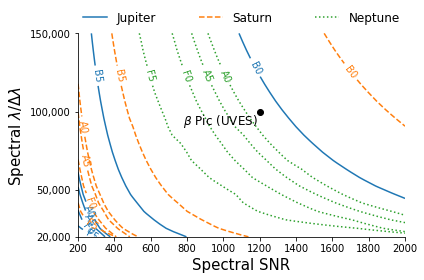

In [19]:
def plot_feasibilitysurvey(SNRspec_list, splanet,
                           snr_lim, inputfolder, Nobs = 21):
    """
    Description:
        Create a plot showing where the SNR is above a certain level
        for different stellar spectral types, spectral resolutions and
        spectral SNRs.
    Input:
        SNRspec_list - list of spectral resolutions
        splanet - list of planet signals
        snr_lim - limting exoplanet SNR to use
        inputfolder - folder containing the simulated lineprofiles
        Nobs - number of observations per epoch
    """
    
    # load the simulation data
    Rinst_list = np.load(os.path.join(inputfolder, 'obs/Rinst_list.npy'))
    starparams = np.load(os.path.join(inputfolder, 'sim/starparams.npy'))
    Rp_list = np.load(os.path.join(inputfolder, 'sim/Rp_list.npy'))

    # create figure
    plt.close()
    fig, ax = plt.subplots()
    snr = np.zeros((starparams.shape[0], len(Rp_list), len(Rinst_list),
                    len(SNRspec_list)))
    for i in range(starparams.shape[0]):
        for j, Rp in enumerate(Rp_list):
            for k, Rinst in enumerate(Rinst_list):
                
                # get signal and binsize
                signal = splanet[i, j, k, 0]
                binsize = splanet[i, j, k, 1]
                
                for l, SNRspec in enumerate(SNRspec_list):

                    # caculcate snr
                    noise = np.sqrt(binsize)/(SNRspec * np.sqrt(Nobs))
                    snr[i, j, k, l] = signal/noise
            
    ls_list = ['-', '--', ':']
    for i in range(starparams.shape[0]):
        for j, Rp in enumerate(Rp_list):
            
            # create contours for different spectral types
            y = np.linspace(0, 1, len(Rinst_list))
            x = np.linspace(0, 1, len(SNRspec_list))
            X, Y = np.meshgrid(x, y)
            
            # as expected some contours are outside of the figure range which
            # rises a warning. These are deliberately silenced.
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                cs = plt.contour(X, Y, np.flipud(snr[i, j, :, :]),
                                 levels = [snr_lim],
                                 colors = [tableau20[j * 2]],
                                 linestyles = [ls_list[j]], zorder = 1)
                
            fmt = {snr_lim: str(starparams[i, 0])}
            plt.clabel(cs, fmt = fmt, fontsize=10, inline = True)
    
    # add legend
    ax.plot([-10, 10], [-10,-10], color = tableau20[0],
            label = 'Jupiter', ls = ls_list[0])
    ax.plot([-10, 10], [-10,-10], color = tableau20[2],
            label = 'Saturn', ls = ls_list[1])
    ax.plot([-10, 10], [-10,-10], color = tableau20[4],
            label = 'Neptune', ls = ls_list[2])
    
    # plot legends    
    plt.legend(loc = 8, frameon = False, fontsize = 12,
               bbox_to_anchor=(0.5, -0.01), ncol=3)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0., frameon = False,
               fontsize = 12)
    
    # set x- and y limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # set right tick labels
    plt.xlabel('Spectral SNR', size = 15)
    
    # set ticks for the spectral SNR
    N = 10
    xticks = np.linspace(0, 1, N)
    temp = np.linspace(SNRspec_list.min(), SNRspec_list.max(), N)
    xtick_labels = [ str(np.round(x, 1))[:-2] for x in temp]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    
    # set ticks for the spectral resolution
    N = 14
    vinst_list = const.c.to(u.km / u.s).value / Rinst_list
    yticks = np.linspace(0, 1, N)
    temp = np.linspace(vinst_list.min(), vinst_list.max(), N)[::-1]
    ytick_labels = [ str(np.round(x, 2)) for x in temp]

    # plot SNR for the Beta Pic observations
    SNRspec_bpic = 1200
    Rinst_bpic = 1e5
    xp = (SNRspec_bpic - SNRspec_list.min())/ \
    (SNRspec_list.max() - SNRspec_list.min())
    yp = (Rinst_bpic - Rinst_list.min())/(Rinst_list.max() - Rinst_list.min())
    ax.scatter([xp], [yp], color = 'k', zorder = 2)
    plt.annotate(r'$\beta$ Pic (UVES)',
                 xy = (xp-0.235, yp-0.065), size = 12, zorder = 2)
    
    # adjust ticks on y-axis
    mask = np.array([0, 3, 8, 13])
    yticks = np.linspace(0, 1, N)[mask]
    ytick_labels = ['20,000', '50,000', '100,000', '150,000']
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_ylabel(r'Spectral $\lambda / \Delta \lambda$',
                   size = 15)
    
    # no spines on top- and right part of the plot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # use tight layout
    plt.tight_layout()
    
    # save figure in the outputfolder and show
    plt.savefig(os.path.join(inputfolder, 'spectralsurvey.png'), dpi = 300)
    plt.savefig(os.path.join(inputfolder, 'spectralsurvey.pdf'))
    plt.show()

# create plot of the feasibility as a function of the spectral type
SNRspec_list = np.linspace(200, 2000, 25)
inputfolder = '../output/figure8'
snr_lim = 3
plot_feasibilitysurvey(SNRspec_list, splanet, snr_lim, inputfolder)